# Neural Networks
the main file became very messy, so i transferred  the training process for the Neural Networks over to this file
Specifically the most sensible approach to model the system will be to progressively use more complex Neural Network types and stop, once the accuracy is sufficient.


The first step will be 
<u>**Normalization**</u>:
earlier i had the issue that when using the mean 0 centered normalization, ReLU units might be switching off when the test biomass is a lot smaller than the one used in training. So to improve this the normalization:
- Exploit the property that all values strictly $n(m,t),S,u>=0$
- use scales that accurately match the scale 
    - $n$ with log normalization because it ranges from $0$ to $10^{20}$
    - $S$ with simple min-max-scaling because the values only range from $0$ to $5$

The Training_data is inside the [Training_data_integro_diff_batch](link_available_soon) -folder, where the successful model layouts and dictionaries will also be found



TODOS:
- improve training Dataset-->no need to let the model run for 30 seconds if the system dynamics are over after the first few-->model will only learn static points


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
from functools import partial
import pickle
import torch
import torch.nn as nn
from Training_helper import *

## Data import and Normalization
quick note on the Datasets: in the batch case, the dynamics are "slowest" when the initial biomass is at its minimum (but Non-zero) and the initial substrate is at its maximum value.
A quick test revealed that in the batch case and training data in the range of $b \in (0.1,5)$ $S \in (0,4)$ this is occurs for $b=0.1$ and $S=4$. It could be observed, that all the substrate has been used up after the first 10 seconds. For every other experiment, this was even faster. To not "learn" the model on stationary points (where $f(x_{k+1})=f(x_{k})$), the batch case will only cover training on Datasets with a range of 10 seconds

In [2]:
with open("Dataset_training_integro_diff_Batch.pkl", "rb") as f:
    Dataset = pickle.load(f)


first = next(iter(Dataset.values()))
M, T = first["n"].shape
dim=M+1  # +1 for S
t_span=(0,0.1*T)
t_eval= torch.linspace(*t_span,T)
m=torch.linspace(0,2e-10,M)
delta_m=m[1]-m[0]
m_max=m[-1]

n_max = max(torch.tensor(entry["n"], dtype=torch.float32).max() for entry in Dataset.values())
log_n_max = torch.log1p(n_max)   # log(1 + n_max)
S_max = 5   #max possible substrate

X_all, Y_all = [], []

for entry in Dataset.values():
    n = torch.tensor(entry["n"], dtype=torch.float32)  # (M, T)
    s = torch.tensor(entry["S"], dtype=torch.float32)  # (T,)

    n_norm = n / n_max#torch.log1p(n) / log_n_max                # log scaling
    s_norm = s / S_max         

    # X_t = [n(t), s(t)]
    X = torch.cat([n_norm[:, :-1], s_norm[:-1].unsqueeze(0)], dim=0).T   # shape (T-1, M+1)
    # Y_t = [n(t+1), s(t+1)]
    Y = torch.cat([n_norm[:, 1:],  s_norm[1:].unsqueeze(0)], dim=0).T    # shape (T-1, M+1)

    X_all.append(X)
    Y_all.append(Y)

# final stacked tensors
X_train = torch.cat(X_all, dim=0)  # shape: (total_samples, M+1)
Y_train = torch.cat(Y_all, dim=0)  # shape: (total_samples, M+1)
print(T)



100


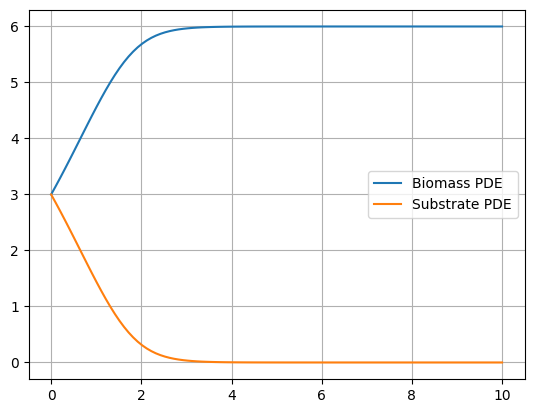

In [ ]:
#original pde system
with open("Dataset_validation_integro_diff_Batch.pkl", "rb") as f:
    Dataset_validation = pickle.load(f)
N_pde= Dataset_validation[0]["n"]
S_pde=Dataset_validation[0]["S"]
B_pde=[]
for i in range(T):
    B_pde.append(sum(N_pde[:,i]*m.numpy()*delta_m.numpy()))
plt.plot(t_eval,B_pde,label="Biomass PDE")
plt.plot(t_eval, S_pde,label="Substrate PDE")
plt.legend()
plt.grid()

plt.show()
plot_spaghetti(m=m,t=torch.linspace(0,20,T),N=N_pde,title="original model prediction")

# Standard Artificial Neural Network


In [30]:

class Neuralnetwork(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, dim)
        )
    def forward(self, x):
        return self.model(x)

model=Neuralnetwork(dim)
model,loss = train_the_model_full_dataset_Adam(model,X_train,Y_train,num_epochs=1000)


Iter 00000 | Loss: 0.036578 | Best: 0.036578 | LR: 1.00e-02
Iter 00100 | Loss: 0.000527 | Best: 0.000489 | LR: 1.00e-02
Iter 00200 | Loss: 0.000072 | Best: 0.000072 | LR: 1.00e-02
Iter 00300 | Loss: 0.000015 | Best: 0.000015 | LR: 5.00e-03
Iter 00400 | Loss: 0.000010 | Best: 0.000010 | LR: 5.00e-03
Iter 00500 | Loss: 0.000008 | Best: 0.000008 | LR: 5.00e-03
Iter 00600 | Loss: 0.000007 | Best: 0.000007 | LR: 5.00e-03
Iter 00700 | Loss: 0.000006 | Best: 0.000006 | LR: 5.00e-03
Iter 00800 | Loss: 0.000005 | Best: 0.000005 | LR: 2.50e-03
Iter 00900 | Loss: 0.000004 | Best: 0.000004 | LR: 2.50e-03


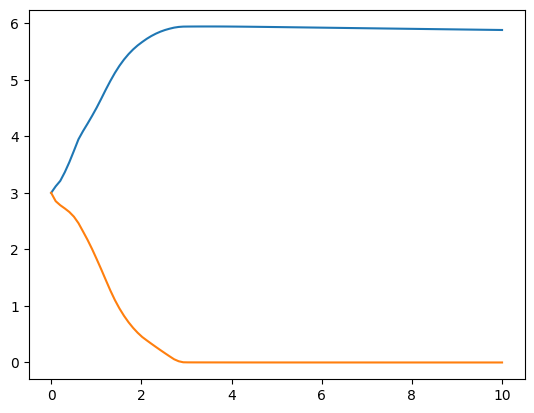

In [31]:

#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_nn,S_nn = rollout(model=model, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_nn,title="Neural network prediction")
biomass_nn  = (N_nn  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
plt.plot(t_eval,biomass_nn,label="Neural Network Biomass")
plt.plot(t_eval,S_nn,label="Neural Network Substrate")


# Conditioning Bias (Additive part of Film)
One potential issue could be that the substrate that actually plays a vital role in how the states evolve gets underestimated in the Network, as it is "only" one of 101 input parameters!
My idea now is to push the Substrate through a linear layer and then adding this to the input vector-->S has a lot more influence on each parameter! 

In [6]:
class Input_Enhance_Net(nn.Module):
    def __init__(self, M, H=101):
        super().__init__()
        self.enc_n = nn.Sequential(nn.Linear(M, H), nn.ReLU())
        self.enc_s = nn.Sequential(nn.Linear(1, H), nn.ReLU())          # saturating path for S
        
        self.block  = nn.Sequential(
            nn.Linear(H,128), nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, dim)
        )

    def forward(self, x):
        # x = [n(M), S]
        n, S = x[..., :M], x[..., M:M+1]
        h = self.enc_n(n) + self.enc_s(S)  # S and u injected at hidden width
        return self.block(h)
    
model2= Input_Enhance_Net(M=M)
model2, loss = train_the_model_full_dataset_Adam(model2,X_train,Y_train,num_epochs=300)

Iter 00000 | Loss: 0.036130 | Best: 0.036130 | LR: 1.00e-02
Iter 00100 | Loss: 0.000945 | Best: 0.000945 | LR: 1.00e-02
Iter 00200 | Loss: 0.000259 | Best: 0.000259 | LR: 1.00e-02


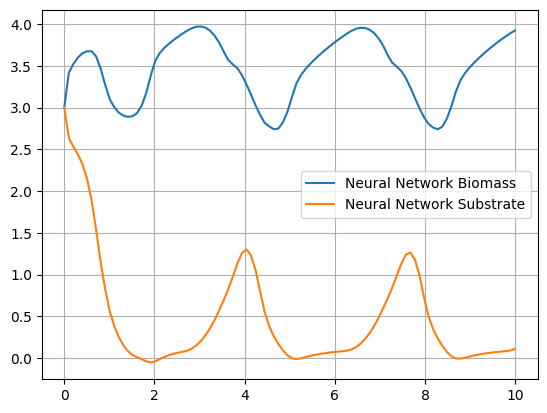

In [7]:
#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_input_enhanced,S_input_enhanced = rollout(model=model2, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_input_enhanced,title="Neural network - input enhanced- prediction")
biomass_input_enhanced  = (N_input_enhanced  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
plt.plot(t_eval,biomass_input_enhanced,label="Neural Network Biomass")
plt.plot(t_eval,S_input_enhanced,label="Neural Network Substrate")
plt.legend()
plt.grid()
plt.show()

# FILM (Feature Wise Linear Modulation)
A detailed introduction can be found in this [Article](https://distill.pub/2018/feature-wise-transformations/)

in the box above i only added S to the layer, now i want to create a true Film neural network. Given that both additive and multiplicative interactions seem natural and intuitive, which approach should we pick? One argument in favor of multiplicative interactions is that they are useful in learning relationships between inputs, as these interactions naturally identify “matches”: multiplying elements that agree in sign yields larger values than multiplying elements that disagree. This property is why dot products are often used to determine how similar two vectors are. 2 One argument in favor of additive interactions is that they are more natural for applications that are less strongly dependent on the joint values of two inputs, like feature aggregation or feature detection (i.e., checking if a feature is present in either of two inputs).

In the spirit of making as few assumptions about the problem as possible, we may as well combine both into a conditional affine transformation.

In [8]:

class FiLM_Net(nn.Module):
    def __init__(self, M, H=128):
        super().__init__()
        self.M = M

        # Encoder for n
        self.enc_n = nn.Sequential(
            nn.Linear(M, H),
            nn.ReLU()
        )

        # FiLM generator for S
        self.film_gen = nn.Sequential(
            nn.Linear(1, H),
            nn.ReLU(),
            nn.Linear(H, 2*H)   # outputs [gamma, beta]
        )

        # Main block
        self.block = nn.Sequential(
            nn.Linear(H, 128), nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, 128),nn.ReLU(),
            nn.Linear(128, dim)
        )

    def forward(self, x):
        # Split input
        n, S = x[..., :self.M], x[..., self.M:self.M+1]

        # Encode n
        h = self.enc_n(n)   # (batch, H)

        # Generate FiLM params from S
        film_params = self.film_gen(S)         # (batch, 2H)
        gamma, beta = film_params.chunk(2, dim=-1)  # each (batch, H)

        # Apply FiLM modulation
        h = gamma * h + beta

        # Continue with main block
        return self.block(h)
    
model3= FiLM_Net(M=M)
model3, loss = train_the_model_full_dataset_Adam(model3,X_train,Y_train,num_epochs=300)

Iter 00000 | Loss: 0.036215 | Best: 0.036215 | LR: 1.00e-02
Iter 00100 | Loss: 0.000722 | Best: 0.000721 | LR: 1.00e-02
Iter 00200 | Loss: 0.000426 | Best: 0.000422 | LR: 1.00e-02


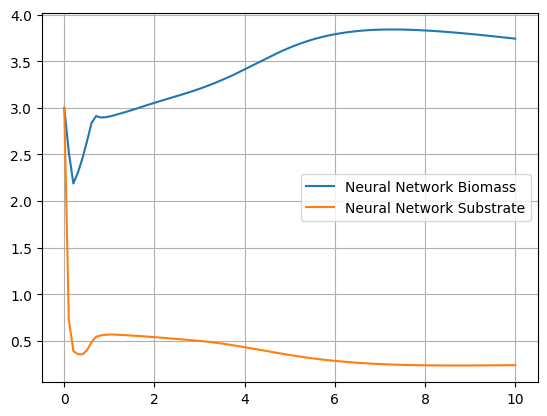

In [9]:
#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_Film,S_Film = rollout(model=model3, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_Film,title="Neural network - input enhanced- prediction")
biomass_Film=(N_Film  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
plt.plot(t_eval,biomass_Film,label="Neural Network Biomass")
plt.plot(t_eval,S_Film,label="Neural Network Substrate")
plt.legend()
plt.grid()
plt.show()

# Residual Neural Networks
the key idea of Resnets is to reduce the vanishing gradient when training models with deep layers. It does so by learning
$$ 
x_{out}=F(x_{in})+x_{in}
$$
instead of 
$$
x_{out} = F(x_{in})
$$
This way, if $F(x)$ learns the output 0, the state can just flow through unchanged. 
Another thing which is particularily interesting for our application is that
$$
x_{out}=x_{k+1},  x_{in}=x_{k}
$$
so the Function $F(X)$ that is being learned can be interpreted as the Euler-step integration!
Using Resnets also has the advantadge that deep layers can be employed more easily
In a way, a ResNet can be interpreted as the discrete form NODE that we introduced in the simple biosystem case.

In [10]:

class ResidualBlock(nn.Module):         #building bricks for ResNet
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
        
    def forward(self, x):
        return x + self.block(x)   # residual connection
    
class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=3):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        # stack residual blocks
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for _ in range(num_blocks)])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h = torch.relu(self.input_layer(x))
        h = self.blocks(h)
        return self.output_layer(h)

model4 = ResNet(input_dim=M+1, hidden_dim=256, output_dim=M+1, num_blocks=5)
model4, loss = train_the_model_full_dataset_Adam(model4,X_train,Y_train,num_epochs=300)

Iter 00000 | Loss: 0.041852 | Best: 0.041852 | LR: 1.00e-02
Iter 00100 | Loss: 0.002794 | Best: 0.002794 | LR: 1.00e-02
Iter 00200 | Loss: 0.000909 | Best: 0.000909 | LR: 1.00e-02


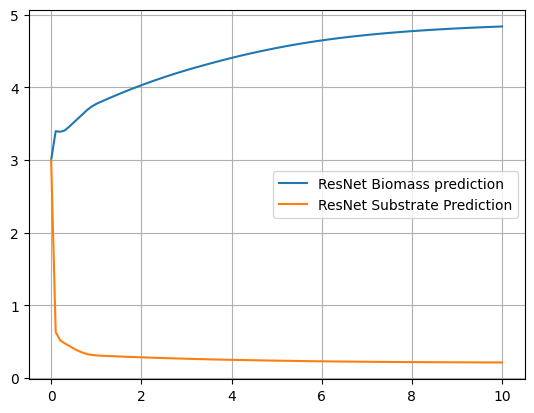

In [11]:
#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_Resnet,S_Resnet = rollout(model=model4, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_Resnet,title="ResNet prediction")
biomass_Resnet  = (N_Resnet  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()

plt.plot(t_eval,biomass_Resnet,label="ResNet Biomass prediction")
plt.plot(t_eval,S_Resnet,label="ResNet Substrate Prediction")
plt.legend()
plt.grid()
plt.show()

# Convolutional Neural  Networks (+ FiLM for substrate)
Convolutional Neural Networks (CNNs) work by applying kernels (filters) across the input. A kernel is a small matrix of learnable weights that is shared across the entire input domain. As the kernel slides over the input with a defined stride length, it computes local weighted combinations of nearby values.

This weight sharing means the same kernel is applied at multiple positions, which greatly reduces the number of parameters compared to fully connected layers.

Because convolution focuses on local neighborhoods, elements that are close to one another are treated as having stronger interactions. This makes CNNs especially well-suited for data with local structure, such as images or discretized solutions of PDEs, where values at nearby spatial or temporal points strongly influence each other.
$$
y[m,n] \;=\; \sum_{i=0}^{k-1} \sum_{j=0}^{k-1} K[i,j] \, x[m-i,\,n-j]
$$

The issue would be, that the last entry per dataset is the substrate, and it actually affects *ALL* entries of the Distribution. So naturally it makes sense to include this by using a **FiLM-network** on top

In [12]:
class FiLM1D(nn.Module):
    """Feature-wise affine modulation: h' = gamma * h + beta (per-channel)."""
    def __init__(self, cond_dim: int, channels: int, use_sigmoid_gamma=True):
        super().__init__()
        self.use_sigmoid_gamma = use_sigmoid_gamma
        self.mlp = nn.Sequential(
            nn.Linear(cond_dim, 64), nn.ReLU(),
            nn.Linear(64, 2 * channels)  # -> [gamma, beta]
        )
        # Initialize near identity (gamma≈1, beta≈0)
        with torch.no_grad():
            self.mlp[-1].weight.zero_()
            self.mlp[-1].bias.zero_()

    def forward(self, h, s):
        """
        h: (B, C, M) conv features
        s: (B, cond_dim) conditioning input (e.g., S(t))
        """
        gb = self.mlp(s)                      # (B, 2C)
        gamma, beta = gb.chunk(2, dim=-1)     # (B, C), (B, C)
        if self.use_sigmoid_gamma:
            gamma = 2.0 * torch.sigmoid(gamma)  # keep gamma in (0,2) around 1
        gamma = gamma.unsqueeze(-1)           # (B, C, 1)
        beta  = beta.unsqueeze(-1)            # (B, C, 1)
        return gamma * h + beta

class ConvFiLM1D_VectorIO(nn.Module):
    """
    Input:  x_t = [ n(m,t) length M,  S(t) ]  shape (B, M+1)
    Output: y_t = [ n(m,t+dt) length M,  S(t+dt) ]  shape (B, M+1)

    - Conv over n for local interactions.
    - FiLM from scalar S to modulate channels globally.
    - n_{t+dt} predicted by conv head.
    - S_{t+dt} predicted by an MLP on pooled conv features concatenated with S(t),
      so S depends on n and S.
    """
    def __init__(self, M=100, channels=64, use_sigmoid_gamma=True):
        super().__init__()
        self.M = M

        # Local conv feature extractor over n(m,t)
        self.enc = nn.Sequential(
            nn.Conv1d(1, channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(channels, channels, kernel_size=5, padding=2),
            nn.ReLU(),
        )

        # FiLM from S(t)
        self.film = FiLM1D(cond_dim=1, channels=channels, use_sigmoid_gamma=use_sigmoid_gamma)

        # Head to predict next n(m,t+dt)
        self.n_head = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(channels, 1, kernel_size=1)
        )

        # Head to predict S(t+dt) from pooled features AND current S(t)
        #   h_pool = GAP(h_film) ∈ R^{B×C}
        #   concat with S(t) ∈ R^{B×1}  -> R^{B×(C+1)}
        self.S_head = nn.Sequential(
            nn.Linear(channels + 1, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.gap = nn.AdaptiveAvgPool1d(1)  # global average over mass axis

    def forward(self, x):
        n = x[..., :self.M]           # (B, M)
        S = x[..., self.M:self.M+1]   # (B, 1)

        h = self.enc(n.unsqueeze(1))  # (B, C, M)
        h = self.film(h, S)           # FiLM modulation

        # predict n_{t+dt}
        n_next = self.n_head(h).squeeze(1)     # (B, M)

        # predict S_{t+dt}
        h_pool = self.gap(h).squeeze(-1)       # (B, C)
        s_feat = torch.cat([h_pool, S], dim=-1)  # (B, C+1)
        S_next = self.S_head(s_feat)           # (B, 1)

        y = torch.cat([n_next, S_next], dim=-1)  # (B, M+1)
        return y
    
model5 = ConvFiLM1D_VectorIO(M=100, channels=32)
model5, loss = train_the_model_full_dataset_Adam(model5,X_train,Y_train,num_epochs=300)



Iter 00000 | Loss: 0.020065 | Best: 0.020065 | LR: 1.00e-02
Iter 00100 | Loss: 0.000019 | Best: 0.000019 | LR: 1.00e-02
Iter 00200 | Loss: 0.000015 | Best: 0.000015 | LR: 1.00e-02


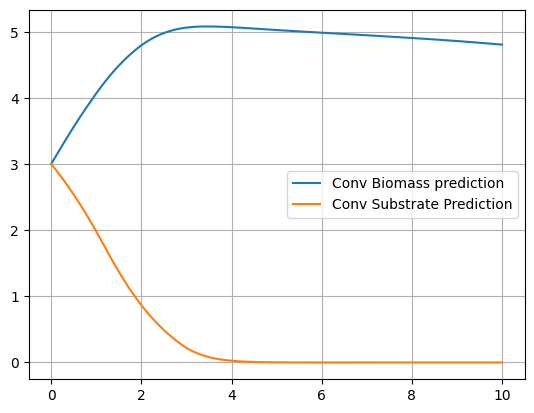

In [13]:
#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_Conv,S_Conv = rollout(model=model5, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_Conv,title="ResNet prediction")
biomass_Conv  = (N_Conv  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
plt.plot(t_eval,biomass_Conv,label="Conv Biomass prediction")
plt.plot(t_eval,S_Conv,label="Conv Substrate Prediction")
plt.legend()
plt.grid()
plt.show()

# ResNet + Conv_Net + FilM
now i try to combine all of these approaches to maybe get a complex model that is capable of capturing the dynamics

In [14]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class FiLM1D(nn.Module):
    """Feature-wise affine modulation: h' = gamma * h + beta (per-channel)."""
    def __init__(self, cond_dim: int, channels: int, use_sigmoid_gamma=True):
        super().__init__()
        self.use_sigmoid_gamma = use_sigmoid_gamma
        self.mlp = nn.Sequential(
            nn.Linear(cond_dim, 64), nn.ReLU(),
            nn.Linear(64, 2 * channels)  # -> [gamma, beta]
        )
        with torch.no_grad():
            self.mlp[-1].weight.zero_()
            self.mlp[-1].bias.zero_()

    def forward(self, h, s):
        gb = self.mlp(s)                      # (B, 2C)
        gamma, beta = gb.chunk(2, dim=-1)     # (B, C), (B, C)
        if self.use_sigmoid_gamma:
            gamma = 2.0 * torch.sigmoid(gamma)
        gamma = gamma.unsqueeze(-1)           # (B, C, 1)
        beta  = beta.unsqueeze(-1)            # (B, C, 1)
        return gamma * h + beta


class ConvFiLM1D_ResNet(nn.Module):
    """
    Residual update:
        x_{t+dt} = x_t + f(x_t)
    where x_t = [ n(m,t), S(t) ] ∈ R^{M+1}
    Works with both (B, M+1) and (M+1,).
    """
    def __init__(self, M=100, channels=64, use_sigmoid_gamma=True):
        super().__init__()
        self.M = M

        # Conv feature extractor over n
        self.enc = nn.Sequential(
            nn.Conv1d(1, channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(channels, channels, kernel_size=5, padding=2),
            nn.ReLU(),
        )

        # FiLM from S
        self.film = FiLM1D(cond_dim=1, channels=channels,
                           use_sigmoid_gamma=use_sigmoid_gamma)

        # Head for delta n
        self.n_head = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(channels, 1, kernel_size=1)
        )

        # Head for delta S
        self.S_head = nn.Sequential(
            nn.Linear(channels + 1, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.gap = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        added_batch = False
        if x.ndim == 1:           # input (M+1,)
            x = x.unsqueeze(0)    # -> (1, M+1)
            added_batch = True

        n = x[..., :self.M]           # (B, M)
        S = x[..., self.M:self.M+1]   # (B, 1)

        # conv features with FiLM
        h = self.enc(n.unsqueeze(1))  # (B, C, M)
        h = self.film(h, S)           # (B, C, M)

        # delta n
        dn = self.n_head(h).squeeze(1)   # (B, M)

        # delta S
        h_pool = self.gap(h).squeeze(-1)   # (B, C)
        s_feat = torch.cat([h_pool, S], dim=-1)  # (B, C+1)
        dS = self.S_head(s_feat)           # (B, 1)

        # residual update
        n_next = n + dn
        S_next = S + dS
        # n_next = torch.sigmoid(self.n_head(h).squeeze(1))
        # S_next = torch.sigmoid(self.S_head(torch.cat([h_pool, S], -1)))
        y = torch.cat([n_next, S_next], dim=-1)  # (B, M+1)

        if added_batch:
            return y[0]  # (M+1,)
        return y       
model6 = ConvFiLM1D_ResNet(M=100, channels=32)
model6, loss = train_the_model_full_dataset_Adam(model6,X_train,Y_train,num_epochs=20)

Iter 00000 | Loss: 0.033724 | Best: 0.033724 | LR: 1.00e-02


[ 3.00000048e+00  2.05182886e+00  1.07022226e+00  4.56655696e-02
 -1.02824366e+00 -2.15674615e+00 -3.34625864e+00 -4.60308361e+00
 -5.93444061e+00 -7.34857416e+00 -8.85075951e+00 -1.04466076e+01
 -1.21477613e+01 -1.39643707e+01 -1.59064579e+01 -1.79838676e+01
 -2.02062035e+01 -2.25928135e+01 -2.51578732e+01 -2.79161434e+01
 -3.08930721e+01 -3.41936836e+01 -3.79431496e+01 -4.22611771e+01
 -4.72674675e+01 -5.30890121e+01 -5.98771095e+01 -6.78250046e+01
 -7.71898499e+01 -8.82766800e+01 -1.01397346e+02 -1.16908325e+02
 -1.35272751e+02 -1.57031815e+02 -1.82799759e+02 -2.13313599e+02
 -2.49443665e+02 -2.92203461e+02 -3.42751373e+02 -4.02365570e+02
 -4.72627197e+02 -5.55508789e+02 -6.53536438e+02 -7.70007874e+02
 -9.09325134e+02 -1.07734717e+03 -1.28185498e+03 -1.53278320e+03
 -1.84294507e+03 -2.22924585e+03 -2.71315698e+03 -3.32087012e+03
 -4.08345728e+03 -5.03751172e+03 -6.22698877e+03 -7.70620703e+03
 -9.54348730e+03 -1.18248652e+04 -1.46580566e+04 -1.81777207e+04
 -2.25510762e+04 -2.79866

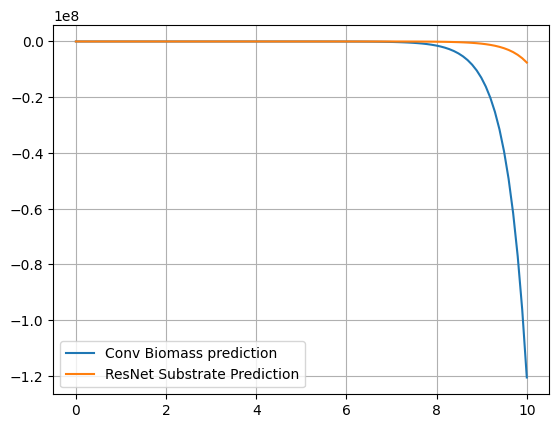

In [15]:
#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_Res_Con_Film,S_Res_Con_Film = rollout(model=model6, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_Res_Con_Film,title="ResNet prediction")
biomass_Res_Con_Film  = (N_Res_Con_Film  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
print(biomass_Res_Con_Film)
plt.plot(t_eval,biomass_Res_Con_Film,label="Conv Biomass prediction")
plt.plot(t_eval,S_Res_Con_Film,label="ResNet Substrate Prediction")
plt.legend()
plt.grid()
plt.show()

In [16]:
class FiLM1D(nn.Module):
    """
    Feature-wise Linear Modulation conditioned on the scalar S.
    Produces gamma(S) and beta(S) to modulate conv features: y = gamma * x + beta
    """
    def __init__(self, num_channels, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.LeakyReLU(0.01),
            nn.Linear(hidden, 2 * num_channels)
        )

    def forward(self, feats, S_scalar):
        # feats: (B, C, L), S_scalar: (B, 1)
        gb = self.net(S_scalar)               # (B, 2C)
        C = feats.size(1)
        gamma, beta = gb[:, :C], gb[:, C:]    # (B, C), (B, C)
        # reshape for broadcast over length L
        gamma = gamma.unsqueeze(-1)           # (B, C, 1)
        beta  = beta.unsqueeze(-1)            # (B, C, 1)
        return gamma * feats + beta


class CNNForwardShift(nn.Module):
    """
    Input:  X = concat([n(m,t) (length M), S(t)])  shape (B, M+1)  -- normalized
    Output: Y = concat([n(m,t+1), S(t+1)])         shape (B, M+1)  -- normalized
    """
    def __init__(self, M, hidden_channels=64, kernel_size=5, depth=3):
        super().__init__()
        pad = kernel_size // 2                 # "same" length for odd kernels

        self.in_conv = nn.Conv1d(1, hidden_channels, kernel_size=kernel_size, padding=pad)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=kernel_size, padding=pad),
                nn.LeakyReLU(0.01),
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=kernel_size, padding=pad)
            )
            for _ in range(depth)
        ])
        self.activ = nn.LeakyReLU(0.01)
        self.film  = FiLM1D(hidden_channels, hidden=64)

        # Head to produce delta n(m): conv 1x1
        self.n_head = nn.Conv1d(hidden_channels, 1, kernel_size=1)

        # Global pooling + MLP to predict S(t+1)
        self.pool = nn.AdaptiveAvgPool1d(1)   # (B, C, 1)
        self.s_head = nn.Sequential(
            nn.Linear(hidden_channels + 1, 64), nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )

        self.M = M

    def forward(self, X):
        # split X into n and S
        n = X[:, :self.M]           # (B, M)
        S = X[:, self.M:self.M+1]   # (B, 1)

        # conv trunk over n
        x = n.unsqueeze(1)          # (B, 1, M)
        x = self.in_conv(x)         # (B, C, M)
        x = self.activ(x)

        # FiLM-modulated residual blocks
        for blk in self.blocks:
            res = x
            h = blk(x)              # (B, C, M)
            h = self.film(h, S)     # condition on S(t)
            x = self.activ(h + res)

        # n-head: residual update
        dn = self.n_head(x).squeeze(1)   # (B, M)
        n_next = n + dn                  # residual learning helps stability

        # S-head: pooled features + S
        g = self.pool(x).squeeze(-1)     # (B, C)
        s_in = torch.cat([g, S], dim=1)  # (B, C+1)
        S_next = self.s_head(s_in)       # (B, 1)

        # concatenate to match training/normalization shapes
        Y = torch.cat([n_next, S_next], dim=1)  # (B, M+1)
        return Y

model7 = CNNForwardShift(M=M, hidden_channels=32, kernel_size=5, depth=3)
model7, loss = train_the_model_full_dataset_Adam(model7, X_train, Y_train, num_epochs=300)

Iter 00000 | Loss: 0.017534 | Best: 0.017534 | LR: 1.00e-02
Iter 00100 | Loss: 0.000026 | Best: 0.000026 | LR: 1.00e-02
Iter 00200 | Loss: 0.000016 | Best: 0.000016 | LR: 1.00e-02


[ 3.0000005   3.1192977   3.2277868   3.3265345   3.4315996   3.5431669
  3.6614897   3.7868805   3.9195616   4.0598717   4.2078457   4.3575783
  4.495554    4.616654    4.7344155   4.8561573   4.9822946   5.110009
  5.236581    5.3619947   5.486657    5.6116586   5.737273    5.8635006
  5.9891577   6.1125274   6.234564    6.351252    6.4565434   6.5492535
  6.6302524   6.7010355   6.7628293   6.816232    6.8619294   6.900655
  6.9331713   6.9602084   6.9824605   6.9987283   7.0071454   7.0079975
  7.001573    6.9882474   6.9678254   6.9407744   6.907521    6.8683033
  6.8233695   6.7730713   6.717825    6.65787     6.593438    6.523823
  6.4492764   6.3664594   6.275848    6.178126    6.073762    5.9631157
  5.8462305   5.7232356   5.5942674   5.4595814   5.3193088   5.173578
  5.0226483   4.8666544   4.705216    4.537806    4.365034    4.1881385
  4.0082555   3.8260176   3.6419826   3.4563258   3.2695017   3.0808036
  2.8899791   2.6968439   2.5014005   2.3035839   2.103473    1.9015

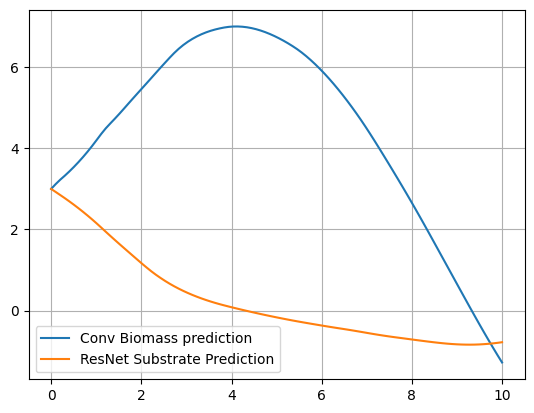

In [17]:
#prediction step
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_Res_Con_Film,S_Res_Con_Film = rollout(model=model7, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_Res_Con_Film,title="ResNet prediction")
biomass_Res_Con_Film  = (N_Res_Con_Film  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
print(biomass_Res_Con_Film)
plt.plot(t_eval,biomass_Res_Con_Film,label="Conv Biomass prediction")
plt.plot(t_eval,S_Res_Con_Film,label="ResNet Substrate Prediction")
plt.legend()
plt.grid()
plt.show()

# Fourier Neural Networks

learn a function mapping operator

In [28]:
# -----------------------------
# 1. Fourier Layer
# -----------------------------
class SpectralConv1d(nn.Module):
    """
    1D Fourier layer: FFT -> linear transform on low modes -> IFFT
    """
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # number of Fourier modes to keep

        # complex weights for low-frequency modes
        self.weights = nn.Parameter(
            torch.randn(in_channels, out_channels, modes, dtype=torch.cfloat) /
            (in_channels * out_channels)
        )

    def compl_mul1d(self, input, weights):
        # input: (batch, in_channel, modes)
        # weights: (in_channel, out_channel, modes)
        return torch.einsum("bim,iom->bom", input, weights)

    def forward(self, x):
        # x: (batch, in_channels, N)
        batchsize, channels, N = x.shape

        # FFT
        x_ft = torch.fft.rfft(x, dim=-1)  # (batch, in_channels, N//2+1)

        # keep only first self.modes
        out_ft = torch.zeros(batchsize, self.out_channels, N//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(
            x_ft[:, :, :self.modes], self.weights
        )

        # inverse FFT
        x = torch.fft.irfft(out_ft, n=N, dim=-1)  # (batch, out_channels, N)
        return x


# -----------------------------
# 2. Base FNO model
# -----------------------------
class FNO1d(nn.Module):
    def __init__(self, modes, width, in_channels=1, out_channels=1, depth=4):
        """
        modes: number of Fourier modes kept
        width: latent channel size
        depth: number of Fourier layers
        """
        super().__init__()
        self.modes = modes
        self.width = width
        self.depth = depth

        self.fc0 = nn.Linear(in_channels, width)

        self.fourier_layers = nn.ModuleList()
        self.ws = nn.ModuleList()
        for _ in range(depth):
            self.fourier_layers.append(SpectralConv1d(width, width, modes))
            self.ws.append(nn.Conv1d(width, width, 1))  # local linear

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        # x: (batch, N, in_channels)
        x = self.fc0(x)  # (batch, N, width)
        x = x.permute(0, 2, 1)  # (batch, width, N)

        for i in range(self.depth):
            x1 = self.fourier_layers[i](x)
            x2 = self.ws[i](x)
            x = x1 + x2
            x = torch.relu(x)

        x = x.permute(0, 2, 1)  # (batch, N, width)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)  # (batch, N, out_channels)
        return x


# -----------------------------
# 3. Wrapper for your dataset format
# -----------------------------
class FNO1dWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model

    def forward(self, x):
        # x: (batch, M+1)   -> from your dataset
        x = x.unsqueeze(-1)            # -> (batch, M+1, 1)
        y = self.base(x)               # -> (batch, M+1, 1)
        return y.squeeze(-1)           # -> (batch, M+1)


base_fno = FNO1d(modes=24, width=64, in_channels=1, out_channels=1, depth=4)
model8 = FNO1dWrapper(base_fno)
model8.train()
model8, best_loss = train_the_model_full_dataset_Adam(model, X_train, Y_train, num_epochs=1000)

Iter 00000 | Loss: 0.020847 | Best: 0.020847 | LR: 1.00e-02
Iter 00100 | Loss: 0.000027 | Best: 0.000027 | LR: 1.00e-02
Iter 00200 | Loss: 0.000013 | Best: 0.000011 | LR: 1.00e-02
Iter 00300 | Loss: 0.000010 | Best: 0.000008 | LR: 1.00e-02
Iter 00400 | Loss: 0.000006 | Best: 0.000006 | LR: 5.00e-03
Iter 00500 | Loss: 0.000005 | Best: 0.000005 | LR: 5.00e-03
Iter 00600 | Loss: 0.000005 | Best: 0.000005 | LR: 5.00e-03
Iter 00700 | Loss: 0.000004 | Best: 0.000004 | LR: 5.00e-03
Iter 00800 | Loss: 0.000004 | Best: 0.000004 | LR: 5.00e-03
Iter 00900 | Loss: 0.000004 | Best: 0.000003 | LR: 5.00e-03


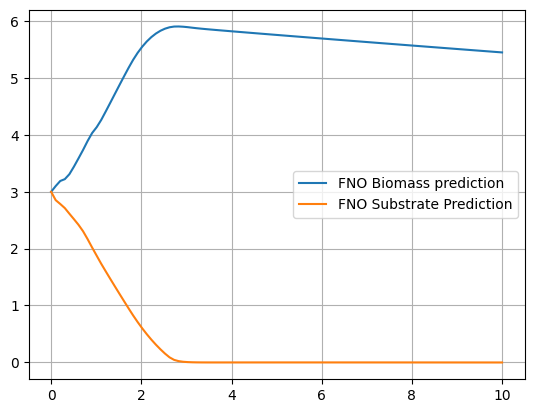

In [29]:
n0=Dataset_validation[0]["n"][:,0]
S0=Dataset_validation[0]["initial_substrate"]
N_FNO,S_FNO = rollout(model=model8, n0=n0, s0=S0, steps=T-1, n_max=n_max, S_max=S_max,return_numpy=True)

plot_spaghetti(m=m,t=torch.linspace(0,10,T),N=N_FNO,title="ResNet prediction")
biomass_FNO  = (N_FNO  * m.numpy()[:,None]).sum(axis=0) * delta_m.numpy()
plt.plot(t_eval,biomass_FNO,label="FNO Biomass prediction")
plt.plot(t_eval,S_FNO,label="FNO Substrate Prediction")
plt.legend()
plt.grid()
plt.show()